<h1 style="font-size:40px;"><center>Counting corners in polygons with a<br> Convolutional Neural Network
</center></h1>

In this notebook, I design a CNN network to count the corners of polygons in images from an archive. Images are found in the same working directory as this notebook along with the target labels. 

The number of corners ranges from 3 to 10.

In [1]:
import numpy as np
import tensorflow as tf
import time

import numpy as np
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

from sklearn.metrics import *

import matplotlib
import matplotlib.pyplot as plt

import imageio.v2 as imageio

Define a function to load the polygon images 

In [2]:
# functions for loading the images from the course Deep learning, Lund university (2022)
def loadImages(folder,trgFile,n):
    def load_pics(folder,n):
        imgs = []
        for i in range(n):
            img = imageio.imread(folder+"img_{:05}.png".format(i+1))
            ch = img[:,:,0]
            imgs.append(ch)
        return np.array(imgs)

    def load_labels(fn):
        return np.loadtxt(fn, usecols=0)

    pic = load_pics(folder+"/", n)
    ndata, width, height = pic.shape

    inp = (pic/np.float32(255)).reshape(n, width, height, 1)
    trg = load_labels(trgFile)
    trg = trg[0:n]

    return inp, trg, width, height


def loadData(nTrn, nTst):
    # Load data
    (trnInp, trnTrg, imgW, imgH) = loadImages("polyAll-trn", "polyAll-trn_trg.csv", nTrn)
    (tstInp, tstTrg, imgW, imgH) = loadImages("polyAll-tst", "polyAll-tst_trg.csv", nTst)

    if tf.keras.backend.image_data_format() == 'channels_first':
        trnInp = trnInp.reshape(trnInp.shape[0], 1, imgH, imgW)
        tstInp = tstInp.reshape(tstInp.shape[0], 1, imgH, imgW)
        input_shape = (1, imgH, imgW)
    else:
        trnInp = trnInp.reshape(trnInp.shape[0], imgH, imgW, 1)
        tstInp = tstInp.reshape(tstInp.shape[0], imgH, imgW, 1)
        input_shape = (imgH, imgW, 1)

    #print('trnInp shape:', trnInp.shape)
    #print('tstInp shape:', tstInp.shape)

    #trnTrg /= 10;
    #tstTrg /= 10;
    
    #sanna convert so that 0 means 3 and 7 means 10 etc
    trnTrg -= 3;
    tstTrg -= 3;

    return trnInp, trnTrg, tstInp, tstTrg, input_shape


Load and plot some example images

Dimensions of images:  (100, 100, 1)
Targets:
[2. 6. 3. 7. 3. 2. 2. 3. 1. 6.]
acctual number of corners:  [ 5.  9.  6. 10.  6.  5.  5.  6.  4.  9.]


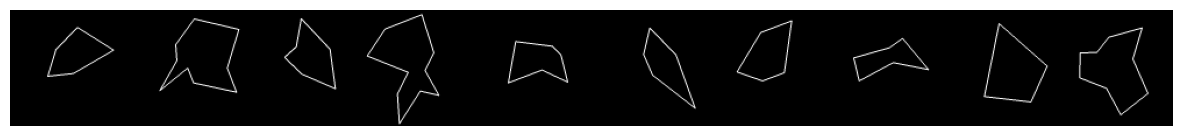

In [3]:
xplot, yplot, xplot2, yplot2, plotdata_shape = loadData(10,10)

print('Dimensions of images: ' , plotdata_shape)

plt.figure(1, figsize=(15,10))
plt.imshow(xplot[:10,:,:].swapaxes(0,1).reshape(100,10*100),cmap="gray")
plt.axis("off")
#plt.savefig('example_data')
print("Targets:")
print(yplot[:10])
print('acctual number of corners: ', yplot[:10]+3)

* Load the dataset: training data and test data
* Make images binary (optional)
* Reserve 20% of the training data for validation

In [4]:
# Load the dataset
xtrain, ytrain, xtest, ytest, input_shape = loadData(5000,5000)

print('Shape of training data' , xtrain.shape)

#pre-proprocessing
# make all pixels < threshold black
#threshold = 0.1
#xtrain = 1.0 * (xtrain_in > threshold)
#xtest = 1.0 * (xtest_in > threshold)

# Reserve some samples for validation
val_param = int(xtrain.shape[0]*0.2)
print('Size of validation set: ', val_param)
xval = xtrain[0:val_param]
yval = ytrain[0:val_param]
xtrain = xtrain[val_param:]
ytrain = ytrain[val_param:]

Shape of training data (5000, 100, 100, 1)
Size of validation set:  1000


## CNN architecture

In [5]:

model = Sequential([
    Conv2D(16, kernel_size = (3, 3),
           activation='relu',input_shape = input_shape, padding = 'same'),
    Conv2D(16, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(pool_size = (2, 2)),
    Flatten(),    #(dense layer needs a 1D input)
    Dense(128, activation='relu', kernel_regularizer = regularizers.l1_l2(0.0008, 0.008)),
    Dropout(0.5),
    Dense(8),            # 8 options output
    Activation('softmax')
])


Define training configuration (optimizer, loss, metrics)

In [6]:
# the loss function, optimization function
adam = Adam(learning_rate = 0.005)
#rms = RMSprop(learning_rate = 0.008)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                    

# Train the model

Train the model with the training data and validate with the validation data.



In [7]:

estimator = model.fit(xtrain, ytrain, 
                      epochs = 150, 
                      batch_size = 200, #64,#try something ~ between 20 and 200
                      verbose = 1,
                      validation_data = (xval, yval))


estimator.history
print('Accuracy: ', estimator.history['accuracy'][-1])
print(' Validation accuracy: ', estimator.history['val_accuracy'][-1])

Epoch 1/150
20/20 [==============================] - 12s 524ms/step - loss: 4.2896 - accuracy: 0.1797 - val_loss: 2.7125 - val_accuracy: 0.1960
Epoch 2/150
20/20 [==============================] - 9s 464ms/step - loss: 2.4891 - accuracy: 0.2323 - val_loss: 2.2288 - val_accuracy: 0.2750
Epoch 3/150
20/20 [==============================] - 10s 504ms/step - loss: 2.2036 - accuracy: 0.2652 - val_loss: 2.0853 - val_accuracy: 0.3120
Epoch 4/150
20/20 [==============================] - 10s 495ms/step - loss: 2.1305 - accuracy: 0.2923 - val_loss: 2.0557 - val_accuracy: 0.3220
Epoch 5/150
20/20 [==============================] - 11s 530ms/step - loss: 2.0541 - accuracy: 0.3203 - val_loss: 1.9755 - val_accuracy: 0.3390
Epoch 6/150
20/20 [==============================] - 10s 494ms/step - loss: 2.0072 - accuracy: 0.3460 - val_loss: 1.9361 - val_accuracy: 0.3740
Epoch 7/150
20/20 [==============================] - 10s 515ms/step - loss: 1.9267 - accuracy: 0.3717 - val_loss: 1.8803 - val_accuracy: 

Training and validation plots

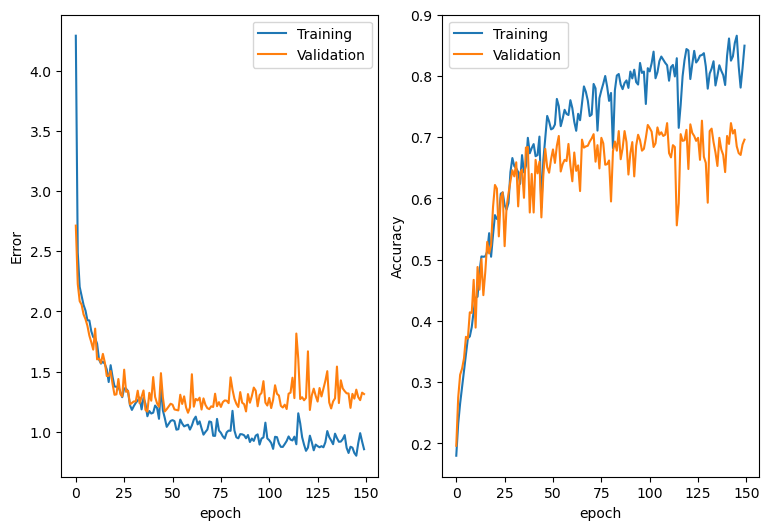

In [8]:
plt.figure(1, figsize = (9,6))
plt.subplot(121)
# Plot the training error
plt.plot(estimator.history['loss'], label = 'Training')
plt.plot(estimator.history['val_loss'], label = 'Validation')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend()
#plt.show()

# Plot the accuracy
plt.subplot(122)
plt.plot(estimator.history['accuracy'], label = 'Training')
plt.plot(estimator.history['val_accuracy'], label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()


# Evaluate
Time to evaluate the model with the test data

In [10]:
print('Evaluating model: ')
scores = model.evaluate(xtest, ytest, batch_size = 128) #prints out score. 
print("test loss, test acc:", round(scores[0], 4), round(scores[1], 4))


Evaluating model: 
40/40 [==============================] - 3s 75ms/step - loss: 1.3130 - accuracy: 0.7074
test loss, test acc: 1.313 0.7074


# Results summary

- Around 70% polygons were correctly classified 
- Model is slightly overtrained

# What went wrong? Examples of correct and wrongly classified polygons

* Showing typical example of polygons that were harder to identify
* Display the filters


Starting with a correctly classified polygon:

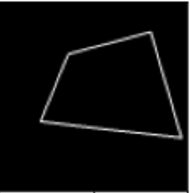
predicted as 4 corners:
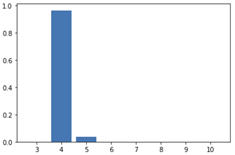

the filters convoluted with this polygon look like this: 
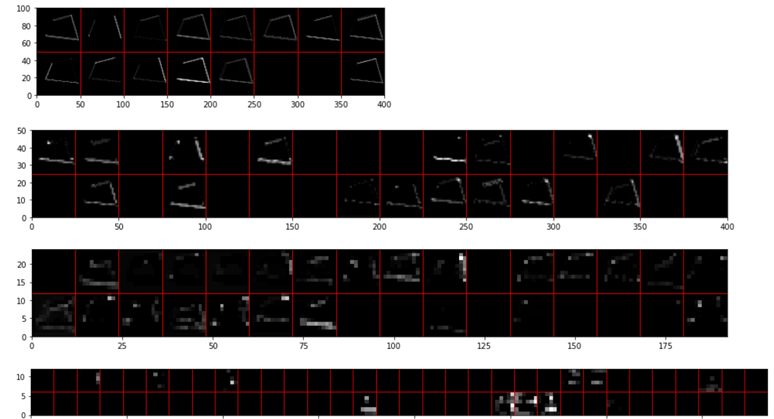

* Note how the edges are identified in the earlier convolutional filters

and an example of a wrongly classified polygon:

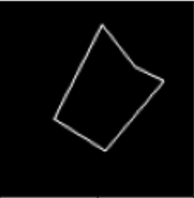 classified as:

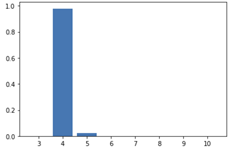

Note that:
* one of the corners are close to 180 degrees which is most probably the corner that is not counted
* there is an existing, but lower, propability for 5 corners

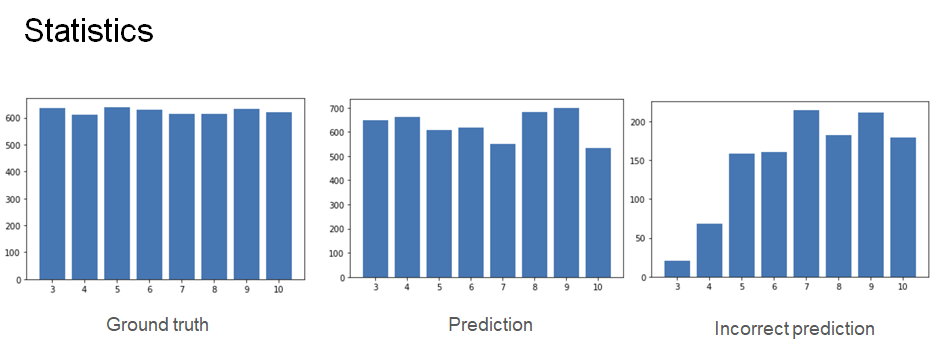